In [40]:
###Functions that generate simulated data, and split the simulated data into train, cal and test.
import numpy as np
from scipy.stats import weibull_min
from sympy import symbols, Eq, solve
import math


def find_beta(R_squared,error):
    """
    input:
    R_squared: 
    error: homo or hetero
    
    output:
    beta: a scaler
    """
    assert error in ['homo','hetero'], 'error must be homo or hetero!'
    
    beta=symbols('beta')
    if error=='homo':
        equation=Eq((0.5-math.log(2)**2)*beta**2-R_squared*((0.5-math.log(2)**2)*beta**2+1),0)
        solutions=solve(equation,beta)
        beta_hat=[sol.evalf() for sol in solutions if sol > 0]
    else:
        equation=Eq((0.5-math.log(2)**2)*beta**2-R_squared*((0.5-math.log(2)**2)*beta**2+2.0201),0)
        solutions=solve(equation,beta)
        beta_hat=[sol.evalf() for sol in solutions if sol > 0]
    
    return beta_hat

def generate_data(n,d,R_squared,error):
    """
    n: sample size
    d: dimensionality of X, e.g, d=11
    R_squared: 
    error: homo or hetero
    
    """
    assert error in ['homo','hetero'], 'error must be homo or hetero!'
    
    X_real=X = np.random.exponential(1, size=n)

    beta_hat=find_beta(R_squared,error)
    
    
    Y_reg=beta_hat*np.exp(X_real)/(1+np.exp(X_real))
    
    
    if error=='homo':
        eps=np.random.normal(loc=0,scale=1,size=n)
    else:
        eps0=np.random.normal(loc=0,scale=1,size=n)
        eps=(0.01+X_real)*eps0
    
    Y=Y_reg+eps
    
    mean_of_Xreal=np.mean(X_real)
    var_of_Xreal=np.var(X_real)
    
    X=np.zeros((n,d))
    
    for i in range(d):
        X[:,i]=(X_real-mean_of_Xreal)**i*np.exp(-(X_real-mean_of_Xreal)**2/(2*var_of_Xreal))
    
    
    data={'X':X,'Y':Y,'X_real':X_real}
    return data
        
def split_data(data,n0,n1,n,d_set='train'):
    """
    n0:train data
    n1: calibration data
    n:test data
    """
    assert d_set in ['train', 'cal','test'], 'd_set must be train, cal, or test.'
    
    if d_set=='train':
        X=data['X'][:n0]
        Y=data['Y'][:n0]
        X_real=data['X_real'][:n0]
    elif d_set=='cal':
        X=data['X'][n0:(n0+n1)]
        Y=data['Y'][n0:(n0+n1)]
        X_real=data['X_real'][n0:(n0+n1)]
    else:
        X=data['X'][n0+n1:]
        Y=data['Y'][n0+n1:]
        X_real=data['X_real'][n0+n1:]
        
    data_split={'X':X,'Y':Y,'X_real':X_real}
    return data_split
        

In [59]:
#####generate data 
def generate_realXY(n,R_squared,error):
    """
    input: the same as generate_data
    
    output:
    X:
    Y:
    """
    assert error in ['homo','hetero'], 'error must be homo or hetero!'
    
    X_real= np.random.exponential(1, size=n)

    beta_hat=find_beta(R_squared,error)
    
    
    Y_reg=beta_hat*np.exp(X_real)/(1+np.exp(X_real))
    
    
    if error=='homo':
        eps=np.random.normal(loc=0,scale=1,size=n)
    else:
        eps0=np.random.normal(loc=0,scale=1,size=n)
        eps=(0.01+X_real)*eps0
    
    Y=Y_reg+eps
    data={'X_real':X_real,'Y':Y}
    
    return data

def generate_XY(X_real,Y,d):
    """
    input:
    X_real: n dimensional
    Y: n dimensional
    d:
    
    output:
    X:
    Y:
    X_real:
    
    
    """
    n=len(Y)
    mean_of_Xreal=np.mean(X_real)
    var_of_Xreal=np.var(X_real)
    
    X=np.zeros((n,d))
    
    for i in range(d):
        X[:,i]=(X_real-mean_of_Xreal)**i*np.exp(-(X_real-mean_of_Xreal)**2/(2*var_of_Xreal))
    
    
    data={'X':X,'Y':Y,'X_real':X_real}
    return data


In [42]:
####Some useful Functions, including find_bandwidth, find_kernel_weights, quantile_corrected and weighted_quantile
def find_bandwidth(Xreal_train,Xreal_cal):
    X=np.concatenate((Xreal_train,Xreal_cal))
    n_X=len(X)

    h_matrix=np.full((n_X,n_X),np.nan)
    for i in range(n_X):
        for j in range(i+1,n_X):
            h_matrix[i,j]=np.abs(X[i]-X[j])
    h=np.nanmedian(h_matrix)
    
    return h

def find_kernel_weights(X,x_datapoint,h):
    """
    input:
    X: n dimensional array
    x_datapoint: a single data point, 1 dimensional array
    h: bandwidth
    
    output:
    kernel_weights: n dimensional array
    """
    n_X=len(X)
    distances=np.zeros(n_X)
    
    distances=(X-x_datapoint)**2
    
    kernel=np.exp(-distances/(2*h**2))
    kernel_weights=kernel/np.sum(kernel)
    
    return kernel_weights

def quantile_corrected(x,alpha):
    n_x=len(x)
    if(1-alpha)*(1+1/n_x)>1:
        return np.inf
    else:
        return np.quantile(x,(1-alpha)*(1+1/n_x))

def weighted_quantile(scores,weights,alpha):
    """
    input:
    scores: n dimensional array
    weights: n dimensional array. Note that scores and weights are one-to-one.
    
    output:
    quantile: a scalar
    
    """
    scores_sorted=np.sort(scores)
    indices=np.argsort(scores)
    weights_sorted=weights[indices]
    cumulative_weights=np.cumsum(weights_sorted)
    index = np.where(cumulative_weights >= 1-alpha)[0][0]
    quantile=scores_sorted[index]
    
    return quantile


In [43]:
from sklearn.linear_model import LinearRegression
import copy
def fit_candidate_model(X_train,Y_train,M):
    """
    input: 
    X_train: n*d dimensiolal 
    Y_train: n dim
    M: the number of candidate models
    
    output:
    M candidate trained models
    """
    candidate_models=[]
    for i in range(M):
        X_train_candidate=copy.deepcopy(X_train[:,0:i+1])
        trained_model = LinearRegression(n_jobs=2).fit(X_train_candidate,Y_train)
        candidate_models.append(trained_model)
    
    return candidate_models

def jackknife_prediction(X_train,Y_train,M):
    """
    input: 
    X_train: n*d dimensiolal array
    Y_train: n dim array
    M: the number of candidate models
    
    output:
    prediction_jackknife: n_train*M dimensional array
    """
    n_train=len(Y_train)
    prediction_jackknife=np.zeros((M,n_train))
    
    for i in range(M):
        X_train_candidate=copy.deepcopy(X_train[:,0:i+1])
        for j in range(n_train):
            X_train_jackknife=np.delete(X_train_candidate,j,axis=0)
            Y_train_jackknife=np.delete(Y_train,j)
            trained_model = LinearRegression(n_jobs=2).fit(X_train_jackknife,Y_train_jackknife)
            
            X_test_jackknife=X_train_candidate[j,:].reshape(1, -1)
            prediction_jackknife[i,j]=trained_model.predict(X_test_jackknife)
    
    prediction_jackknife=prediction_jackknife.T
    return prediction_jackknife


In [44]:
###Function that find the optimal weights
from qpsolvers import solve_qp
import scipy.sparse as sp
def weights_criterion_jackknife(Y_train,prediction_jackknife,candidate_interval_lengths,penalty_coef,criterion):
    """
    input:
    Y_train: n dimensional array
    prediction_jackknife: n*M dim
    candidate_interval_lengths: M dimensional array
    penalty_coef: i.e.,lambda, a scalar
    criterion: ordinary, no_penalty, or penalty
    
    output:
    optimal_weights: M dimensional array
    
    """
    assert criterion in ['ordinary','no_penalty','penalty'], 'criterion must be ordinary, no_penalty, or penalty!'
    
    n_train=prediction_jackknife.shape[0]
    M=prediction_jackknife.shape[1]
    A=np.ones(M).reshape((M,))
    A=sp.csc_matrix(A)
    b = np.array([1], dtype=np.double)
    lb=np.zeros(M).reshape((M,))
    ub=np.ones(M).reshape((M,))
    P_kernel=np.eye(n_train)/n_train
    
    if criterion=='ordinary':
        penalty_coef=0
        L=np.zeros((M,M))
    elif criterion=='no_penalty':
        penalty_coef=0
        L=np.zeros((M,M))
    else:
        assert penalty_coef is not None, 'penalty_coef must be specified!'
        assert candidate_interval_lengths is not None, 'candidate_interval_lengths must be specified!'
        penalty_coef=penalty_coef
        L=np.diag(candidate_interval_lengths)
    
    P=2*(prediction_jackknife.T.dot(P_kernel).dot(prediction_jackknife)+penalty_coef*L.T.dot(L))
    P=sp.csc_matrix(P)
    q=-2*prediction_jackknife.T.dot(P_kernel).dot(Y_train)
    optimal_weights=solve_qp(P=P, q=q, A=A, b=b,lb=lb,ub=ub,solver="scs")
    
    return optimal_weights

In [45]:
def predict_basemodel(M_candidate_models,optimal_weights,X_test):
    """
    input:
    M_candidate_models: obtained from the function "fit_candidate_model"
    optimal_weights: M dimensional array
    X_test: n*d dimensianal array
    
    output:
    predictions: n dimensional array
    
    """
    M=len(optimal_weights)
    #check if X_test is a single datapoint
    if X_test.ndim==1:
        predictions_M_candidate=np.zeros((M,1))
        for i in range(M):
            X_test_candidate=copy.deepcopy(X_test[0:i+1]).reshape(1,-1)
            predictions_M_candidate[i,]=M_candidate_models[i].predict(X_test_candidate)
            
    else:
        n_test=X_test.shape[0]
        predictions_M_candidate=np.zeros((M,n_test))
        for i in range(M):
            X_test_candidate=copy.deepcopy(X_test[:,0:i+1])
            predictions_M_candidate[i,]=M_candidate_models[i].predict(X_test_candidate)
        
    predictions=predictions_M_candidate.T.dot(optimal_weights)
    
    return predictions

In [46]:
##Function that implement SCP_MA
def SCP_MA(M_candidate_models,prediction_jackknife,Y_train,X_cal,Y_cal,X_test,alpha):
    """
    Split conformal prediction for model averaging
    input: 
    M_candidate_model:
    prediction_jackknife:
    Y_train:
    X_cal:
    Y_cal:
    X_test:
    alpha:
    
    output:
    interval_predictions:
    
    """
    Y_train=np.array(Y_train,dtype=np.double)
    JMA_weights=weights_criterion_jackknife(Y_train=Y_train,prediction_jackknife=prediction_jackknife,
                                            candidate_interval_lengths=None,penalty_coef=None,criterion='ordinary')
    pred_cal=predict_basemodel(M_candidate_models,JMA_weights,X_cal)
    scores=np.abs(pred_cal-Y_cal)
    q_scores=quantile_corrected(scores, alpha)
    
    pred_test=predict_basemodel(M_candidate_models,JMA_weights,X_test)
    interval_predictions={'y_inf':pred_test-q_scores,
                          'y_sup':pred_test+q_scores}
    
    return interval_predictions
    
    
    

In [47]:
###Functions that compute candidate model lengths
def compute_candidate_model_lengths(M_candidate_models,X_train,Y_train,X_cal,Y_cal,x_testpoint,h,alpha,
                                    Xreal_train,Xreal_cal,xreal_testpoint):
    """
    Compute the prediction length of M candidate models
    input:
    M_candidate_models: 
    X_train:
    Y_train:
    X_cal:
    Y_cal:
    x_testpoint: a single datapoint
    h:
    alpha:
    Xreal_train:
    Xreal_cal:
    xreal_testpoint:
    
    output:
    candidate_model_lengths: M dim
    
    
    """
    M=len(M_candidate_models)
    n_train=len(Y_train)
    n_cal=len(Y_cal)
    candidate_model_lengths=np.zeros(M)
    
    kernel_weights_matrix=np.zeros((n_cal+1,n_train)) #ecah row corresponding to a specific kernel weights
    for i in range(n_cal):
        kernel_weights_matrix[i,]=find_kernel_weights(Xreal_train,Xreal_cal[i],h)
    
    kernel_weights_matrix[-1,:]=find_kernel_weights(Xreal_train,xreal_testpoint,h)
    
    for i in range(M):
        X_train_candidate=copy.deepcopy(X_train[:,0:i+1])
        X_cal_candidate=copy.deepcopy(X_cal[:,0:i+1])
        
        pred_train_candidate=M_candidate_models[i].predict(X_train_candidate)
        pred_cal_candidate=M_candidate_models[i].predict(X_cal_candidate)
        
        scores_train=np.abs(pred_train_candidate-Y_train)
        scores_cal=np.abs(pred_cal_candidate-Y_cal)
        
        ##quantile_weighted:each element corresponding to Q(1-alpha,F_{i}^{h}), for i in [1,...,n+1].
        quantile_weighted=np.zeros(n_cal+1) 
        for j in range(n_cal+1):
            quantile_weighted[j]=weighted_quantile(scores_train,kernel_weights_matrix[j,:],alpha)
        
        V_scores=scores_cal-quantile_weighted[:-1]
        d1=quantile_weighted[-1]+quantile_corrected(V_scores,alpha)
        candidate_model_lengths[i]=2*d1
    
    return candidate_model_lengths

In [48]:
#####Function that implement SLCP_MA 
def SLCP_MA(M_candidate_models,prediction_jackknife,X_train,Y_train,X_cal,Y_cal,X_test,h,penalty_coef,alpha,
            Xreal_train,Xreal_cal,Xreal_test,penalty):
    """
    Split localized conformal prediction for model averaging
    input:
    
    penalty: no, or yes
    
    output:
    interval_predictions:
    
    """
    assert penalty in ['no','yes'],' penalty must be no, or yes!'
    
    Y_train=np.array(Y_train,dtype=np.double)
    n_train=X_train.shape[0]
    n_cal=X_cal.shape[0]
    n_test=X_test.shape[0]
    
    kernel_weights_matrix=np.zeros((n_cal+1,n_train))
    
    for i in range(n_cal):
        kernel_weights_matrix[i,]=find_kernel_weights(Xreal_train,Xreal_cal[i],h)
    
    y_inf=np.zeros(n_test)
    y_sup=np.zeros(n_test)
    for i in range(n_test):
        x_testpoint=X_test[i,]
        xreal_testpoint=Xreal_test[i]
        kernel_weights=find_kernel_weights(Xreal_train,xreal_testpoint,h)
        kernel_weights_matrix[-1,:]=kernel_weights
        
        if penalty=='no':
            optimal_weights=weights_criterion_jackknife(Y_train=Y_train,prediction_jackknife=prediction_jackknife,
                                                        candidate_interval_lengths=None,penalty_coef=None,criterion='no_penalty')
        
        else:
            candidate_interval_lengths=compute_candidate_model_lengths(M_candidate_models,X_train,Y_train,X_cal,Y_cal,x_testpoint,h,alpha,
                                                                       Xreal_train,Xreal_cal,xreal_testpoint)
            optimal_weights=weights_criterion_jackknife(Y_train,prediction_jackknife,
                                                        candidate_interval_lengths,penalty_coef,criterion='penalty')
            
        pred_train=predict_basemodel(M_candidate_models,optimal_weights,X_train)
        pred_cal=predict_basemodel(M_candidate_models,optimal_weights,X_cal)
        
        scores_train=np.abs(pred_train-Y_train)
        scores_cal=np.abs(pred_cal-Y_cal)
        
        quantile_weighted=np.zeros(n_cal+1)
        for j in range(n_cal+1):
            quantile_weighted[j]=weighted_quantile(scores_train,kernel_weights_matrix[j,:],alpha)
        
        V_scores=scores_cal-quantile_weighted[:-1]
        d1=quantile_weighted[-1]+quantile_corrected(V_scores,alpha)
        
        pred_testpoint=predict_basemodel(M_candidate_models,optimal_weights,x_testpoint)
        y_inf[i]=pred_testpoint-d1
        y_sup[i]=pred_testpoint+d1
    
    interval_predictions={'y_inf':y_inf,
                          'y_sup':y_sup}
    
    return interval_predictions

    

In [49]:
###Function that compute interval coveerage and length.
def compute_PI_metrics(interval_predictions,Y_test):
    """
    Compute interval coverage and length.
    """
    contains = (Y_test <= interval_predictions['y_sup']) & (Y_test >= interval_predictions['y_inf'])
    lengths = interval_predictions['y_sup'] - interval_predictions['y_inf']

    coverage=np.mean(contains)
    len=np.mean(lengths)
    metrics={'cov':coverage,
             'len':len}
    return metrics

# Simulation studies

## 1. Compare coverage and interval length of SCP_MA, SLCP_MA1, and SLCP_MA2. Fixed M, different R_squared

In [10]:
R_squared_vec=np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])  ##ranging from 0.1 to 0.9
num_R_squared=len(R_squared_vec)

SCP_cov_vec=np.zeros((num_R_squared,2))
SCP_len_vec=np.zeros((num_R_squared,2))
SLCP1_cov_vec=np.zeros((num_R_squared,2))
SLCP1_len_vec=np.zeros((num_R_squared,2))
SLCP2_cov_vec=np.zeros((num_R_squared,2))
SLCP2_len_vec=np.zeros((num_R_squared,2))

for t in range(num_R_squared):
    n0=50*2    #training set
    n1=50*2    #calibration set
    n=100   #test data
    M=int(3*n0**(1/3))
    error='hetero' #homo or hetero
    penalty_coef=2  #penalty term
    alpha=0.1
    replication=50
    R_squared=R_squared_vec[t]  ##ranging from 0.1 to 0.9

    SCP_MA_cov=np.zeros(replication)
    SCP_MA_len=np.zeros(replication)
    SLCP_MA1_cov=np.zeros(replication)
    SLCP_MA1_len=np.zeros(replication)
    SLCP_MA2_cov=np.zeros(replication)
    SLCP_MA2_len=np.zeros(replication)

    for k in range(replication):
        df=generate_data(n0+n1+n,M,R_squared,error)
        df1=split_data(df,n0,n1,n,d_set='train')
        df2=split_data(df,n0,n1,n,d_set='cal')
        df3=split_data(df,n0,n1,n,d_set='test') 
        h=find_bandwidth(df1['X_real'],df2['X_real'])

        #train M candidate models
        M_candidate_models=fit_candidate_model(df1['X'],df1['Y'],M)

        prediction_jackknife=jackknife_prediction(df1['X'],df1['Y'],M)

        ##################################Compute prediction intervals--------------------------------------------
        SCP_MA_pred_intervals=SCP_MA(M_candidate_models,prediction_jackknife,df1['Y'],df2['X'],df2['Y'],df3['X'],alpha)
        
        
        SLCP_MA1_pred_intervals=SLCP_MA(M_candidate_models,prediction_jackknife,df1['X'],df1['Y'],df2['X'],df2['Y'],
                                        df3['X'],h,penalty_coef,alpha,
                                        df1['X_real'],df2['X_real'],df3['X_real'],'no')
        SLCP_MA2_pred_intervals=SLCP_MA(M_candidate_models,prediction_jackknife,df1['X'],df1['Y'],df2['X'],df2['Y'],
                                        df3['X'],h,penalty_coef,alpha,
                                        df1['X_real'],df2['X_real'],df3['X_real'],'yes')
        
        
        #####
        SCP_MA_metrics=compute_PI_metrics(SCP_MA_pred_intervals,df3['Y'])
        SLCP_MA1_metrics=compute_PI_metrics(SLCP_MA1_pred_intervals,df3['Y'])
        SLCP_MA2_metrics=compute_PI_metrics(SLCP_MA2_pred_intervals,df3['Y'])

        ###
        SCP_MA_cov[k]=SCP_MA_metrics['cov']
        SCP_MA_len[k]=SCP_MA_metrics['len']
        SLCP_MA1_cov[k]=SLCP_MA1_metrics['cov']
        SLCP_MA1_len[k]=SLCP_MA1_metrics['len']
        SLCP_MA2_cov[k]=SLCP_MA2_metrics['cov']
        SLCP_MA2_len[k]=SLCP_MA2_metrics['len']
    
    ######
    SCP_cov_vec[t,0]=np.mean(SCP_MA_cov)
    SCP_len_vec[t,0]=np.mean(SCP_MA_len)
    SLCP1_cov_vec[t,0]=np.mean(SLCP_MA1_cov)
    SLCP1_len_vec[t,0]=np.mean(SLCP_MA1_len)
    SLCP2_cov_vec[t,0]=np.mean(SLCP_MA2_cov)
    SLCP2_len_vec[t,0]=np.mean(SLCP_MA2_len)
  
    SCP_cov_vec[t,1]=np.std(SCP_MA_cov)/(n**0.5)
    SCP_len_vec[t,1]=np.std(SCP_MA_len)/(n**0.5)
    SLCP1_cov_vec[t,1]=np.std(SLCP_MA1_cov)/(n**0.5)
    SLCP1_len_vec[t,1]=np.std(SLCP_MA1_len)/(n**0.5)
    SLCP2_cov_vec[t,1]=np.std(SLCP_MA2_cov)/(n**0.5)
    SLCP2_len_vec[t,1]=np.std(SLCP_MA2_len)/(n**0.5)
    
    
    print(t)
    

0
1
2
3
4
5
6
7
8


In [11]:
print("SCP coverage: ", np.round(SCP_cov_vec[:,0],3))
print("SLCP1 coverage: ", np.round(SLCP1_cov_vec[:,0],3))
print("SLCP2 coverage: ", np.round(SLCP2_cov_vec[:,0],3))
print("SCP length: ", np.round(SCP_len_vec[:,0],3))
print("SLCP1 length: ", np.round(SLCP1_len_vec[:,0],3))
print("SLCP2 length: ", np.round(SLCP2_len_vec[:,0],3))

SCP coverage:  [0.891 0.9   0.887 0.906 0.9   0.902 0.901 0.895 0.907]
SLCP1 coverage:  [0.889 0.896 0.89  0.902 0.906 0.905 0.9   0.894 0.903]
SLCP2 coverage:  [0.884 0.893 0.881 0.899 0.896 0.89  0.898 0.883 0.9  ]
SCP length:  [4.299 4.582 4.503 4.852 4.677 4.779 4.703 4.647 4.859]
SLCP1 length:  [3.326 3.555 3.557 3.769 3.703 3.685 3.689 3.606 3.781]
SLCP2 length:  [3.195 3.41  3.273 3.557 3.439 3.407 3.479 3.364 3.462]


In [12]:
print("SCP coverage (Standard Error): ", np.round(SCP_cov_vec[:,1],3))
print("SLCP1 coverage (Standard Error): ", np.round(SLCP1_cov_vec[:,1],3))
print("SLCP2 coverage (Standard Error): ", np.round(SLCP2_cov_vec[:,1],3))
print("SCP length (Standard Error): ", np.round(SCP_len_vec[:,1],3))
print("SLCP1 length (Standard Error): ", np.round(SLCP1_len_vec[:,1],3))
print("SLCP2 length (Standard Error): ", np.round(SLCP2_len_vec[:,1],3))

SCP coverage (Standard Error):  [0.004 0.004 0.004 0.004 0.004 0.004 0.005 0.005 0.005]
SLCP1 coverage (Standard Error):  [0.004 0.004 0.005 0.005 0.004 0.004 0.004 0.005 0.005]
SLCP2 coverage (Standard Error):  [0.004 0.005 0.004 0.005 0.004 0.005 0.004 0.005 0.005]
SCP length (Standard Error):  [0.082 0.101 0.106 0.133 0.103 0.103 0.115 0.107 0.182]
SLCP1 length (Standard Error):  [0.053 0.084 0.075 0.104 0.085 0.066 0.082 0.074 0.163]
SLCP2 length (Standard Error):  [0.049 0.08  0.057 0.092 0.06  0.064 0.07  0.074 0.065]


In [13]:
import winsound

print("代码已运行完毕")

# 播放系统提示音
winsound.Beep(440, 3000)  # 第一个参数是频率（以赫兹为单位），第二个参数是持续时间（以毫秒为单位）

代码已运行完毕


## 2. Compare coverage and interval length of SCP_MA, SLCP_MA1, and SLCP_MA2. Fixed R_squared, different M

In [91]:
M_vec=np.array([2,3,4,5,6,7,8,9,10])
num_M=len(M_vec)

n0=100    #training set
n1=100   #calibration set
n=100   #test data
error='hetero' #homo or hetero
penalty_coef=2  #penalty term
alpha=0.1
replication=50
R_squared=0.5  ##ranging from 0.1 to 0.9

SCP_cov_matrix=np.zeros((replication,num_M))
SCP_len_matrix=np.zeros((replication,num_M))
SLCP1_cov_matrix=np.zeros((replication,num_M))
SLCP1_len_matrix=np.zeros((replication,num_M))
SLCP2_cov_matrix=np.zeros((replication,num_M))
SLCP2_len_matrix=np.zeros((replication,num_M))


for k in range(replication):
    data=generate_realXY(n0+n1+n,R_squared,error)

    for t in range(num_M):
        M=M_vec[t]
        df=generate_XY(data['X_real'],data['Y'],M)
        
        df1=split_data(df,n0,n1,n,d_set='train')
        df2=split_data(df,n0,n1,n,d_set='cal')
        df3=split_data(df,n0,n1,n,d_set='test') 
        h=find_bandwidth(df1['X_real'],df2['X_real'])
        
        #train M candidate models
        M_candidate_models=fit_candidate_model(df1['X'],df1['Y'],M)

        prediction_jackknife=jackknife_prediction(df1['X'],df1['Y'],M)

        ##################################Compute prediction intervals--------------------------------------------
        SCP_MA_pred_intervals=SCP_MA(M_candidate_models,prediction_jackknife,df1['Y'],df2['X'],df2['Y'],df3['X'],alpha)


        SLCP_MA1_pred_intervals=SLCP_MA(M_candidate_models,prediction_jackknife,df1['X'],df1['Y'],df2['X'],df2['Y'],
                                        df3['X'],h,penalty_coef,alpha,
                                        df1['X_real'],df2['X_real'],df3['X_real'],'no')
        SLCP_MA2_pred_intervals=SLCP_MA(M_candidate_models,prediction_jackknife,df1['X'],df1['Y'],df2['X'],df2['Y'],
                                        df3['X'],h,penalty_coef,alpha,
                                        df1['X_real'],df2['X_real'],df3['X_real'],'yes')


        #####
        SCP_MA_metrics=compute_PI_metrics(SCP_MA_pred_intervals,df3['Y'])
        SLCP_MA1_metrics=compute_PI_metrics(SLCP_MA1_pred_intervals,df3['Y'])
        SLCP_MA2_metrics=compute_PI_metrics(SLCP_MA2_pred_intervals,df3['Y'])

        ###
        SCP_cov_matrix[k,t]=SCP_MA_metrics['cov']
        SCP_len_matrix[k,t]=SCP_MA_metrics['len']
        SLCP1_cov_matrix[k,t]=SLCP_MA1_metrics['cov']
        SLCP1_len_matrix[k,t]=SLCP_MA1_metrics['len']
        SLCP2_cov_matrix[k,t]=SLCP_MA2_metrics['cov']
        SLCP2_len_matrix[k,t]=SLCP_MA2_metrics['len']
    
    print(k)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [92]:
print("SCP coverage: ", np.round(np.mean(SCP_cov_matrix, axis=0),3))
print("SLCP1 coverage: ", np.round(np.mean(SLCP1_cov_matrix, axis=0),3))
print("SLCP2 coverage: ", np.round(np.mean(SLCP2_cov_matrix, axis=0),3))
print("SCP length: ", np.round(np.mean(SCP_len_matrix, axis=0),3))
print("SLCP1 length: ", np.round(np.mean(SLCP1_len_matrix, axis=0),3))
print("SLCP2 length: ", np.round(np.mean(SLCP2_len_matrix, axis=0),3))

SCP coverage:  [0.9   0.895 0.895 0.893 0.892 0.89  0.893 0.891 0.892]
SLCP1 coverage:  [0.905 0.901 0.9   0.903 0.9   0.9   0.901 0.899 0.9  ]
SLCP2 coverage:  [0.904 0.905 0.901 0.9   0.899 0.898 0.897 0.897 0.895]
SCP length:  [4.352 4.172 4.148 4.127 4.118 4.11  4.171 4.153 4.155]
SLCP1 length:  [3.684 3.431 3.381 3.385 3.36  3.341 3.344 3.344 3.331]
SLCP2 length:  [3.827 3.437 3.312 3.25  3.217 3.194 3.219 3.226 3.221]


In [93]:
print("SCP coverage (Standard Error): ", np.round(np.std(SCP_cov_matrix, axis=0)/(n**0.5),3))
print("SLCP1 coverage (Standard Error): ", np.round(np.std(SLCP1_cov_matrix, axis=0)/(n**0.5),3))
print("SLCP2 coverage (Standard Error): ", np.round(np.std(SLCP2_cov_matrix, axis=0)/(n**0.5),3))
print("SCP length (Standard Error): ", np.round(np.std(SCP_len_matrix, axis=0)/(n**0.5),3))
print("SLCP1 length (Standard Error): ", np.round(np.std(SLCP1_len_matrix, axis=0)/(n**0.5),3))
print("SLCP2 length (Standard Error): ", np.round(np.std(SLCP2_len_matrix, axis=0)/(n**0.5),3))

SCP coverage (Standard Error):  [0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004]
SLCP1 coverage (Standard Error):  [0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004]
SLCP2 coverage (Standard Error):  [0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004]
SCP length (Standard Error):  [0.074 0.074 0.07  0.071 0.069 0.069 0.073 0.073 0.077]
SLCP1 length (Standard Error):  [0.045 0.048 0.045 0.046 0.047 0.048 0.048 0.047 0.046]
SLCP2 length (Standard Error):  [0.045 0.04  0.041 0.043 0.046 0.047 0.051 0.052 0.052]


## plots

In [81]:
from scipy.stats import norm
def find_ground_truth_intervals(X,beta,alpha):
    """
    input:
    X: n dimensional array
    beta: a scaler
    
    output:
    ground truth prediction intervals
    
    """
    n_X=len(X)
    y_inf=np.zeros(n_X)
    y_sup=np.zeros(n_X)
    
    mean=beta*np.exp(X)/(1+np.exp(X))
    std=0.01+X
    
    mean = mean.astype(float)  
    std = std.astype(float)  
    
    for i in range(n_X):
        y_inf[i]=norm.ppf(alpha/2, loc=mean[i], scale=std[i])
        y_sup[i]=norm.ppf(1-alpha/2,loc=mean[i],scale=std[i])
    
    interval_predictions={'y_inf':y_inf,
                           'y_sup':y_sup}
    return interval_predictions
    
    

In [82]:
#####
n0=100*10    #training set
n1=100*10    #calibration set
n=100*10   #test data
M=10
error='hetero' #homo or hetero
penalty_coef=2  #penalty term
alpha=0.1
R_squared=0.5  ##ranging from 0.1 to 0.9

df=generate_data(n0+n1+n,M,R_squared,error)
df1=split_data(df,n0,n1,n,d_set='train')
df2=split_data(df,n0,n1,n,d_set='cal')
df3=split_data(df,n0,n1,n,d_set='test') 
h=find_bandwidth(df1['X_real'],df2['X_real'])

#train M candidate models
M_candidate_models=fit_candidate_model(df1['X'],df1['Y'],M)
prediction_jackknife=jackknife_prediction(df1['X'],df1['Y'],M)

##################################Compute prediction intervals--------------------------------------------
SCP_MA_pred_intervals=SCP_MA(M_candidate_models,prediction_jackknife,df1['Y'],df2['X'],df2['Y'],df3['X'],alpha)
SLCP_MA1_pred_intervals=SLCP_MA(M_candidate_models,prediction_jackknife,df1['X'],df1['Y'],df2['X'],df2['Y'],
                                df3['X'],h,penalty_coef,alpha,
                                df1['X_real'],df2['X_real'],df3['X_real'],'no')
SLCP_MA2_pred_intervals=SLCP_MA(M_candidate_models,prediction_jackknife,df1['X'],df1['Y'],df2['X'],df2['Y'],
                                df3['X'],h,penalty_coef,alpha,
                                df1['X_real'],df2['X_real'],df3['X_real'],'yes')
#####
SCP_MA_metrics=compute_PI_metrics(SCP_MA_pred_intervals,df3['Y'])
SLCP_MA1_metrics=compute_PI_metrics(SLCP_MA1_pred_intervals,df3['Y'])
SLCP_MA2_metrics=compute_PI_metrics(SLCP_MA2_pred_intervals,df3['Y'])


In [83]:
import matplotlib.pyplot as plt
###
x = np.array(df1['X_real'], dtype=float) #training dataset
y = np.array(df1['Y'], dtype=float)
x0 = np.array(df3['X_real'], dtype=float) #testing dataset
y0=np.array(df3['Y'],dtype=float)
o = np.argsort(x0)
mar = [4, 4, 3, 0.5]
w = 5
h = 5.5
pcol = "gray"  # 灰色颜色值

beta_hat=find_beta(R_squared,error)
ground_truth_intervals=find_ground_truth_intervals(X=x0,beta=beta_hat,alpha=alpha)


finished


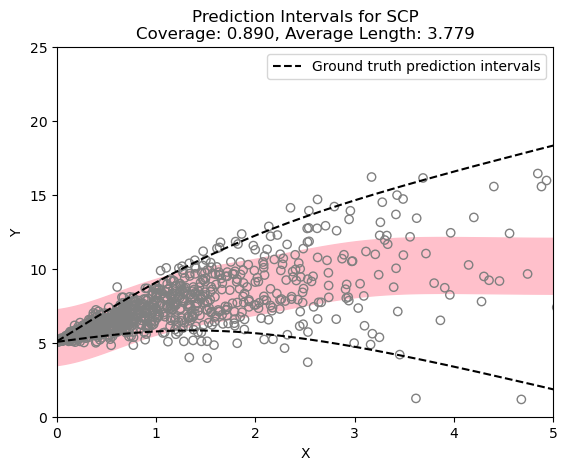

In [85]:
###########SCP
pred_sup_SCP = np.array(SCP_MA_pred_intervals['y_sup'], dtype=float)
pred_inf_SCP = np.array(SCP_MA_pred_intervals['y_inf'], dtype=float)
cov_SCP = np.array(SCP_MA_metrics['cov'], dtype=float)
len_SCP = np.array(SCP_MA_metrics['len'], dtype=float)

# Single plot for the prediction interval of SCP
fig, ax = plt.subplots()
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_xlim(0, 5)
ax.set_ylim(0, 25)
ax.set_title("Prediction Intervals for SCP\nCoverage: {:.3f}, Average Length: {:.3f}".format(cov_SCP, len_SCP))
ax.fill_between(x0[o], pred_inf_SCP[o], pred_sup_SCP[o], color="pink")
ax.plot(x0[o], ground_truth_intervals['y_inf'][o], linestyle='--', color='black', label='Ground truth prediction intervals')
ax.plot(x0[o], ground_truth_intervals['y_sup'][o], linestyle='--', color='black')
ax.scatter(x, y, facecolors="none", edgecolors=pcol, marker="o")  # 使用 facecolors 设置填充颜色为无，使用 edgecolors 指定边缘颜色，marker 设置形状为圆形
ax.legend()

plt.savefig("prediction intervals for SCP.pdf")  # 保存为PDF格式并命名为"prediction.pdf"
print("finished")

finished


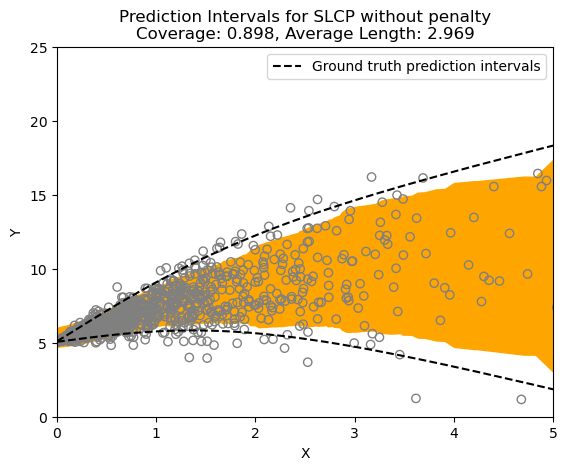

In [86]:
#########SCLP without penalty
pred_sup_SLCP1 = np.array(SLCP_MA1_pred_intervals['y_sup'], dtype=float)
pred_inf_SLCP1 = np.array(SLCP_MA1_pred_intervals['y_inf'], dtype=float)
cov_SLCP1 = np.array(SLCP_MA1_metrics['cov'], dtype=float)
len_SLCP1 = np.array(SLCP_MA1_metrics['len'], dtype=float)


# Single plot for the prediction interval of SLCP without penalty
fig, ax = plt.subplots()
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_xlim(0, 5)
ax.set_ylim(0, 25)
ax.plot(x0[o], ground_truth_intervals['y_inf'][o], linestyle='--', color='black', label='Ground truth prediction intervals')
ax.plot(x0[o], ground_truth_intervals['y_sup'][o], linestyle='--', color='black')
ax.set_title("Prediction Intervals for SLCP without penalty\nCoverage: {:.3f}, Average Length: {:.3f}".format(cov_SLCP1, len_SLCP1))
ax.fill_between(x0[o], pred_inf_SLCP1[o], pred_sup_SLCP1[o], color="orange")
ax.scatter(x, y, facecolors="none", edgecolors=pcol, marker="o")  # 使用 facecolors 设置填充颜色为无，使用 edgecolors 指定边缘颜色，marker 设置形状为圆形
ax.legend()

plt.savefig("prediction intervals for SLCP without penalty.pdf")  # 保存为PDF格式并命名为"prediction.pdf"
print("finished")

finished


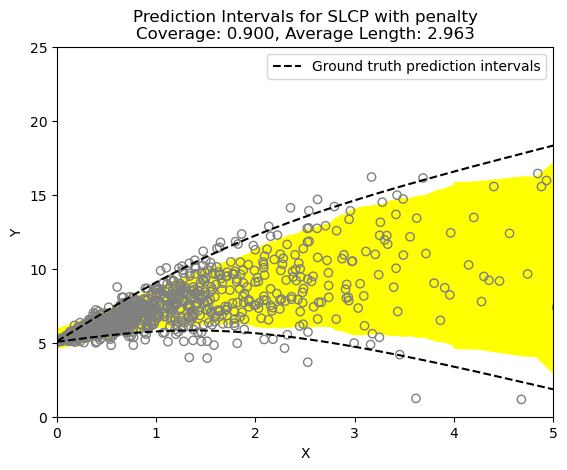

In [87]:
#########SCLP with penalty
pred_sup_SLCP2 = np.array(SLCP_MA2_pred_intervals['y_sup'], dtype=float)
pred_inf_SLCP2 = np.array(SLCP_MA2_pred_intervals['y_inf'], dtype=float)
cov_SLCP2 = np.array(SLCP_MA2_metrics['cov'], dtype=float)
len_SLCP2 = np.array(SLCP_MA2_metrics['len'], dtype=float)


# Single plot for the prediction interval of SLCP with penalty
fig, ax = plt.subplots()
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_xlim(0, 5)
ax.set_ylim(0, 25)
ax.plot(x0[o], ground_truth_intervals['y_inf'][o], linestyle='--', color='black', label='Ground truth prediction intervals')
ax.plot(x0[o], ground_truth_intervals['y_sup'][o], linestyle='--', color='black')
ax.set_title("Prediction Intervals for SLCP with penalty\nCoverage: {:.3f}, Average Length: {:.3f}".format(cov_SLCP2, len_SLCP2))
ax.fill_between(x0[o], pred_inf_SLCP2[o], pred_sup_SLCP2[o], color="yellow")
ax.scatter(x, y, facecolors="none", edgecolors=pcol, marker="o")  # 使用 facecolors 设置填充颜色为无，使用 edgecolors 指定边缘颜色，marker 设置形状为圆形
ax.legend()

plt.savefig("prediction intervals for SLCP with penalty.pdf")  # 保存为PDF格式并命名为"prediction.pdf"
print("finished")